In [3]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile

In [4]:
lr = 0.001 
batch_size = 100
epochs = 10

In [9]:
# for apple silicon gpu
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [10]:
torch.manual_seed(1234)
if device =='mps':
    torch.cuda.manual_seed_all(1234)

In [12]:
os.listdir('/Users/Nian/Desktop/learn/Learn_Projects/CNN_Classfier/dogs-vs-cats-redux-kernels-edition')

['.DS_Store', 'test.zip', 'train.zip', 'sample_submission.csv']

In [13]:
os.makedirs('/Users/Nian/Desktop/learn/Learn_Projects/CNN_Classfier/dogs-vs-cats-redux-kernels-edition', exist_ok=True)
base_dir = '/Users/Nian/Desktop/learn/Learn_Projects/CNN_Classfier/dogs-vs-cats-redux-kernels-edition'
train_dir = '/Users/Nian/Desktop/learn/Learn_Projects/CNN_Classfier/dogs-vs-cats-redux-kernels-edition/train'
test_dir = '/Users/Nian/Desktop/learn/Learn_Projects/CNN_Classfier/dogs-vs-cats-redux-kernels-edition/test'

In [15]:
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('/Users/Nian/Desktop/learn/Learn_Projects/CNN_Classfier/dogs-vs-cats-redux-kernels-edition')
    
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('/Users/Nian/Desktop/learn/Learn_Projects/CNN_Classfier/dogs-vs-cats-redux-kernels-edition')

In [16]:
os.listdir(train_dir)[:5]

['dog.8011.jpg',
 'cat.5077.jpg',
 'dog.7322.jpg',
 'cat.2718.jpg',
 'cat.10151.jpg']

In [17]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
len(train_list)

25000

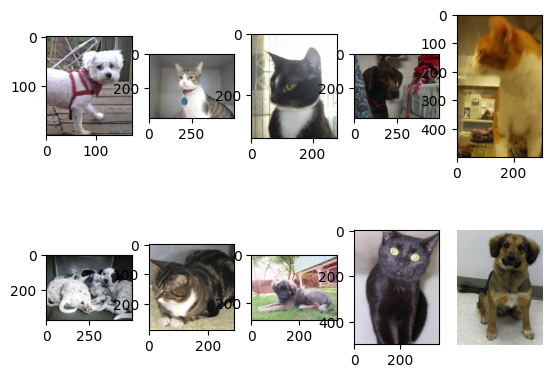

In [18]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [19]:
print(len(train_list), len(test_list))

25000 12500


In [25]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [26]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [27]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [28]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [29]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [30]:
print(len(train_data), len(train_loader))

20000 200


In [31]:
print(len(val_data), len(val_loader))

5000 50


In [32]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [34]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [35]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [36]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [37]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.6399001479148865, train loss : 0.6309562921524048
Epoch : 1, val_accuracy : 0.6687999963760376, val_loss : 0.6013180017471313
Epoch : 2, train accuracy : 0.7060502767562866, train loss : 0.5669184327125549
Epoch : 2, val_accuracy : 0.7155998945236206, val_loss : 0.552521824836731
Epoch : 3, train accuracy : 0.7216001749038696, train loss : 0.5441198348999023
Epoch : 3, val_accuracy : 0.7331997752189636, val_loss : 0.518701434135437
Epoch : 4, train accuracy : 0.7401504516601562, train loss : 0.5176100730895996
Epoch : 4, val_accuracy : 0.7411999106407166, val_loss : 0.5121095776557922
Epoch : 5, train accuracy : 0.7501500844955444, train loss : 0.5057112574577332
Epoch : 5, val_accuracy : 0.7344000339508057, val_loss : 0.518427312374115
Epoch : 6, train accuracy : 0.7562500238418579, train loss : 0.48984795808792114
Epoch : 6, val_accuracy : 0.7463999390602112, val_loss : 0.49792584776878357
Epoch : 7, train accuracy : 0.7626000046730042, train loss : 0.48

In [38]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

In [39]:
dog_probs.sort(key = lambda x : int(x[0]))
dog_probs

[('1', 0.7573763728141785),
 ('2', 0.8918806910514832),
 ('3', 0.8375737071037292),
 ('4', 0.964414656162262),
 ('5', 0.06287933886051178),
 ('6', 0.1805403232574463),
 ('7', 0.6360095143318176),
 ('8', 0.3667864501476288),
 ('9', 0.15667259693145752),
 ('10', 0.1759682446718216),
 ('11', 0.11634502559900284),
 ('12', 0.9819226264953613),
 ('13', 0.39566752314567566),
 ('14', 0.6636567711830139),
 ('15', 0.017757484689354897),
 ('16', 0.3206901252269745),
 ('17', 0.9488791823387146),
 ('18', 0.9587447047233582),
 ('19', 0.37640759348869324),
 ('20', 0.559019148349762),
 ('21', 0.8728074431419373),
 ('22', 0.12748776376247406),
 ('23', 0.10905782878398895),
 ('24', 0.21948273479938507),
 ('25', 0.6817289590835571),
 ('26', 0.8485056757926941),
 ('27', 0.7439413666725159),
 ('28', 0.03871193528175354),
 ('29', 0.882006049156189),
 ('30', 0.7208231091499329),
 ('31', 0.7054539918899536),
 ('32', 0.1601155698299408),
 ('33', 0.9663926362991333),
 ('34', 0.21787741780281067),
 ('35', 0.0133

In [41]:
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))
submission = pd.DataFrame({'id':idx,'label':prob})
submission

,id,label
0,1,0.757376
1,2,0.891881
2,3,0.837574
3,4,0.964415
4,5,0.062879
...,...,...
12495,12496,0.237077
12496,12497,0.257222
12497,12498,0.152051
12498,12499,0.917363


In [46]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)